In [32]:
import pandas
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import sklearn.linear_model
import scipy.optimize
import sklearn.decomposition
import sklearn.manifold
import sklearn.model_selection

Your task is to use and evaluate dimension reduction techniques (PCA and t-SNE) on the California housing dataset. The assignment is at the end of this notebook, in Section 2. First, here is some code
that illustrates PCA and t-SNE.

# 1 Demo code
## 1.1 Import and plot a dataset

We'll use the same dataset as in lecture 1, the World Bank dataset of statistics about states.

In [5]:
url = 'https://raw.githubusercontent.com/ekochmar/cl-datasci-pnp/master/lecture1-introduction/data/country-stats.csv'
countries = pandas.read_csv(url)
countries.iloc[:3]

,Country Name,GDP per Capita (PPP USD),Population Density (persons per sq km),Population Growth Rate (%),Urban Population (%),Life Expectancy at Birth (avg years),Fertility Rate (births per woman),Infant Mortality (deaths per 1000 births),"Enrolment Rate, Tertiary (%)","Unemployment, Total (%)",Estimated Control of Corruption (scale -2.5 to 2.5),Estimated Government Effectiveness (scale -2.5 to 2.5),Internet Users (%)
0,Afghanistan,1560.67,44.62,2.44,23.86,60.07,5.39,71.0,3.33,8.5,-1.41,-1.40,5.45
1,Albania,9403.43,115.11,0.26,54.45,77.16,1.75,15.0,54.85,14.2,-0.72,-0.28,54.66
2,Algeria,8515.35,15.86,1.89,73.71,70.75,2.83,25.6,31.46,10.0,-0.54,-0.55,15.23


Plot a splom. There's lots of messy matplotlib code to make plots look nice, and it calls for frequent use of stackoverflow.

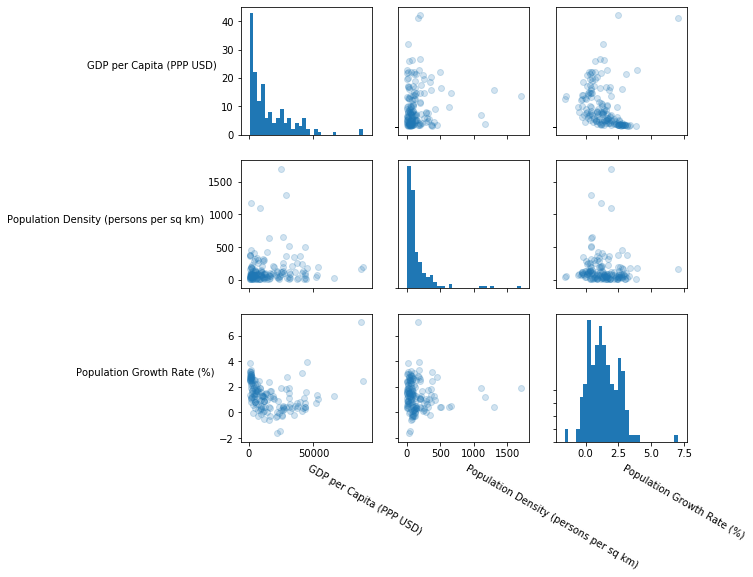

In [20]:
# Pick out the first three columns, excluding "Country Name", to show in the splom
features = countries.columns[1:4]
#len(features)=3
#plt.rc_context: return a context manager for managing rc settings
with plt.rc_context({'figure.figsize': (8,8)}):
    fig,ax = plt.subplots(len(features), len(features), sharex='col', sharey='row')
#number of rows:3
#number of cols:3
#x and y aixes are shared among various plots, with only x labels of the bottom and y labels of the 
#first cols being created

# We'll plot histograms on the diagonal, so they shouldn't share y-axis with the scatter plots
for i in range(len(features)):
    ax[i,i].get_shared_y_axes().remove(ax[i,i])

# Plot histograms or scatter plots as appropriate
# python enumerate: loop over a list and have an automatic counter
for i,c in enumerate(features):
    for j,d in enumerate(features):
        if i == j:
            ax[i,j].hist(countries[d], bins=30)
        else:
            ax[i,j].scatter(countries[d], countries[c], alpha=.2)

# Rotate tick labels to make them legible
for i,c in enumerate(features):
    ax[i,0].set_ylabel(c, rotation=0, horizontalalignment='right')
for j,d in enumerate(features):
    ax[len(features)-1,j].set_xlabel(d, rotation=-30, ha='left')
    #ha: horizontalalignment

plt.show()

## 1.2 One-dimensional PCA

Here is an entirely manual version of one-dimensional PCA. You never need to code PCA yourself, since there are much more efficient libraries to do it for you, but it's useful to see how little there is to it. If you want to build fancier algorithms for dimension reduction, such as autoencoders, you'll have to code similar steps to these, perhaps implementing them in TensorFlow.

Optimization terminated successfully.
         Current function value: 225.098938
         Iterations: 44
         Function evaluations: 85


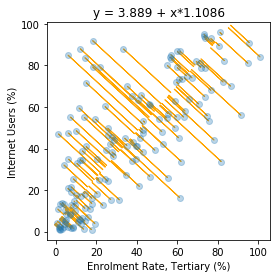

In [23]:
fx,fy = 'Enrolment Rate, Tertiary (%)', 'Internet Users (%)'

# We'll look for a straight line fit   y = m*x + c.
# This isn't the best parameterization (it can't represent a vertical line), but it's simple
# and sufficient for this problem.

def proj(x, y, θ):
    # Given vectors x and y, project them onto the line θ=(m,c)
    m,c = θ
    y0,dx,dy = c,1,m
    d = np.sqrt(dx**2 + dy**2)
    dx,dy = dx/d, dy/d
    #now dx and dy become percentage
    dot = x*dx + (y-y0)*dy
    return dot*dx, y0 + dot*dy

def err(θ):
    # Given straight-line parameters θ=(m,c), find the mean square error of all the projections
    px,py = proj(countries[fx], countries[fy], θ)
    ex,ey = countries[fx]-px, countries[fy]-py
    return np.mean(ex**2 + ey**2)

# Run an optimizer to find the error-minimizing parameters.
# Here I'm using the built in scipy.optimize.fmin.
# You could also implement this with gradient descent.

m,c = scipy.optimize.fmin(err, x0=[.9,10])
#err = function to be minimized
#x0 = ndarray, the initial guess for the parameters

# Project the data onto the fitted straight line
predx,predy = proj(countries[fx], countries[fy], (m,c))

fig,ax = plt.subplots(figsize=(4,4))
ax.scatter(countries[fx], countries[fy], alpha=.3)
for x,y,px,py in zip(countries[fx], countries[fy], predx, predy):
    #zip generates tuples containing elements from the vectors to be zipped
    #in this case, x is enrolment rate, tertiary; y is Internet users; 
    #px is projected enrolment rate; py is projected internet users
    ax.arrow(x,y, px-x,py-y, color='orange', zorder=-1)
# ax.arrow draws an arrow from (x, y) to (x+dx. y+dy)
ax.set_xlabel(fx)
ax.set_ylabel(fy)
plt.title(f"y = {c:.5} + x*{m:.5}")
plt.show()

Here's the same model, fitted using the PCA library function.

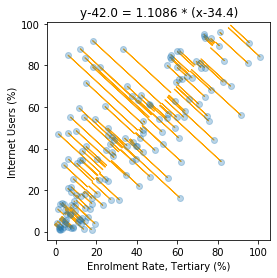

In [28]:
fx,fy = 'Enrolment Rate, Tertiary (%)', 'Internet Users (%)'
X = countries[[fx,fy]].values

pca = sklearn.decomposition.PCA()
#since n_components are not set, all components are kept, i.e. 12 features are all kept
#in this pca
#fit the model with X and apply the dimensionality reduction on X
#hence supposingly, pca_result is 1D
pca_result = pca.fit_transform(X)

# Find the predictions from the PCA model, using just the first component
#per_feature empirical mean, estimated from the training set
μx,μy = pca.mean_
δx,δy = pca.components_[0]
# delta x and delta y are the principal axes in the feature space representing the directions of maximum variance in the data

λ = pca_result[:,0]
predx,predy = μx+λ*δx, μy+λ*δy

fig,ax = plt.subplots(figsize=(4,4))
ax.scatter(X[:,0], X[:,1], alpha=.3)
for x,y,px,py in zip(X[:,0], X[:,1], predx, predy):
    ax.arrow(x,y, (px-x),py-y, color='orange', zorder=-1)
ax.set_xlabel(fx)
ax.set_ylabel(fy)
plt.title(f"y-{μy:.3} = {δy/δx:.5} * (x-{μx:.3})")
plt.show()

## 1.3 Full PCA

Here is the full PCA, run on the entire set of features. 

PCA looks for a good approximation to your dataset, and it treats an error of size $e$ in one feature as just as serious as an error of size $e$ in any other feature. It's therefore wise to scale the features appropriately. If you don't have any real insight into how you should weight them, then just make all your columns have the same variance.

The standard library call fits the model
$$
\vec{x}_i = \vec{\mu} + \sum_{k=1}^K \lambda_{k,i} \vec{\delta}_k
$$
where $K$ is the total number of features in the dataset, and $\vec{x}_i$, $\vec{\mu}$, $\vec{\delta}_k$ are all $K$-dimensional vectors. The basis vectors it returns, $\vec{\delta}_1,\dots,\vec{\delta}_K$, are orthonormal.

PCA puts the components $\vec{\delta}_k$ so that the most important comes first, i.e. so that if you want to approximate the data using only $L<K$ components then you should use the first $L$,
$$
\vec{x}_i = \vec{\mu} + \sum_{k=1}^L \lambda_{k,i} \vec{\delta}_k + \vec{\varepsilon}_i
$$
where the error term $\vec{\varepsilon}_i$ the sum of terms from components $\{L+1,\dots,K\}$. Since the basis vectors
are orthogonal, $\vec{\varepsilon}_i$ is orthogonal to $\{\vec{\delta}_1,\dots,\vec{\delta}_L\}$.

In [124]:
# drop the column 'Country Name', which isn't numeric
features = countries.columns[1:]
X = countries[features].values

# rescale the features, so they have the same variance
for k in range(len(features)):
    X[:,k] = X[:,k] / np.std(X[:,k])

pca = sklearn.decomposition.PCA()
pca_result = pca.fit_transform(X)

# how the results are returned
print("μ:", pca.mean_)
k,i = 2,10
print(f"δ[k={k}]:", pca.components_[k])
print(f"λ[k={k},i={i}]:", pca_result[i,k])

μ: [9.54780563e-01 6.59481318e-01 1.16550076e+00 2.43443295e+00
 8.06247583e+00 1.98804330e+00 1.05052397e+00 1.28125213e+00
 1.22381235e+00 7.32740877e-03 5.19484572e-02 1.45502392e+00]
δ[k=2]: [-0.21521157  0.81173439 -0.18916308 -0.21801048  0.13379205 -0.19250245
 -0.13653149 -0.08295349 -0.30953473 -0.1667017  -0.06814961 -0.05229533]
λ[k=2,i=10]: 4.650211499899461


PCA gives us a nice way to summarize a large number of features in two dimensions.

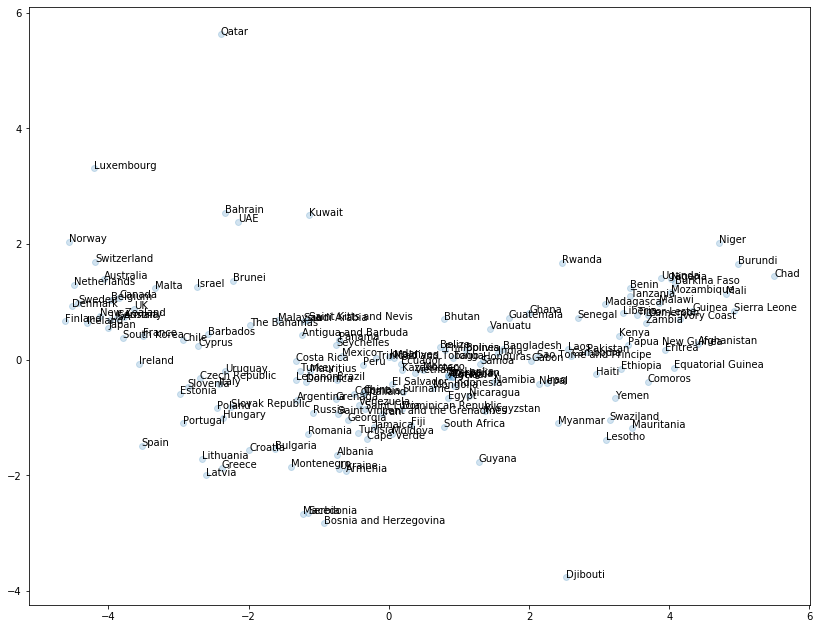

In [127]:
p1,p2 = pca_result[:,0], pca_result[:,1]
#here, only the first two components (i.e. the most important two components)
#are being selected from many more components that the dataset is broken down into

fig,ax = plt.subplots(figsize=(14,11))
ax.scatter(p1, p2, alpha=.2)
for x,y,s in zip(p1,p2,countries['Country Name']):
    ax.text(x,y,s)
plt.show()

## 1.4 t-SNE

t-SNE is another tool for dimension reduction. You have to tell it how many components you want it to produce (unlike PCA, which produces all components and then it's up to you how many to use).

In [36]:
# use all the numerical features, and drop the column 'Country Name'
features = countries.columns[1:]

# as with PCA, we should be careful about the scale of data we present to the algorithm
X = countries[features].values
for k in range(len(features)):
    X[:,k] = X[:,k] / np.std(X[:,k])
    
tsne = sklearn.manifold.TSNE(n_components=2, verbose=1)
#for tSNE, you MUST tell how many components to keep
tsne_results = tsne.fit_transform(X)
tsne_results
#two dimensions for each sample

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 161 samples in 0.000s...
[t-SNE] Computed neighbors for 161 samples in 0.003s...
[t-SNE] Computed conditional probabilities for sample 161 / 161
[t-SNE] Mean sigma: 1.399072
[t-SNE] KL divergence after 250 iterations with early exaggeration: 56.573174
[t-SNE] KL divergence after 900 iterations: 0.337946


array([[ -4.201096  , -13.641963  ],
       [  0.8495032 ,   0.24326953],
       [  1.3828437 ,  -5.440774  ],
       [ -3.1856422 ,  -0.6857662 ],
       [  4.3279157 ,  -3.0180259 ],
       [  0.9983852 ,  -0.13634151],
       [  7.0702634 ,   6.845629  ],
       [  5.94257   ,   6.1057363 ],
       [  1.6845324 ,  -6.641778  ],
       [  0.15848665,   7.2485523 ],
       [ -5.2655106 ,  -2.8061085 ],
       [  1.9246157 ,   6.5866575 ],
       [  4.872739  ,   7.2096114 ],
       [ -0.96009517,  -6.342415  ],
       [ -3.282019  , -13.787152  ],
       [ -2.2393267 ,  -6.889111  ],
       [  2.0050335 ,  -6.049878  ],
       [  1.9514328 ,   0.4544319 ],
       [  2.2434528 ,  -2.316742  ],
       [  6.8766675 ,   3.366141  ],
       [  1.4165146 ,   2.1664636 ],
       [ -3.1118348 , -14.420814  ],
       [ -2.6457233 , -15.592604  ],
       [ -0.60682464,  -9.979102  ],
       [ -3.982765  , -14.063133  ],
       [  6.426171  ,   6.2262993 ],
       [ -0.32120258,  -0.6031798 ],
 

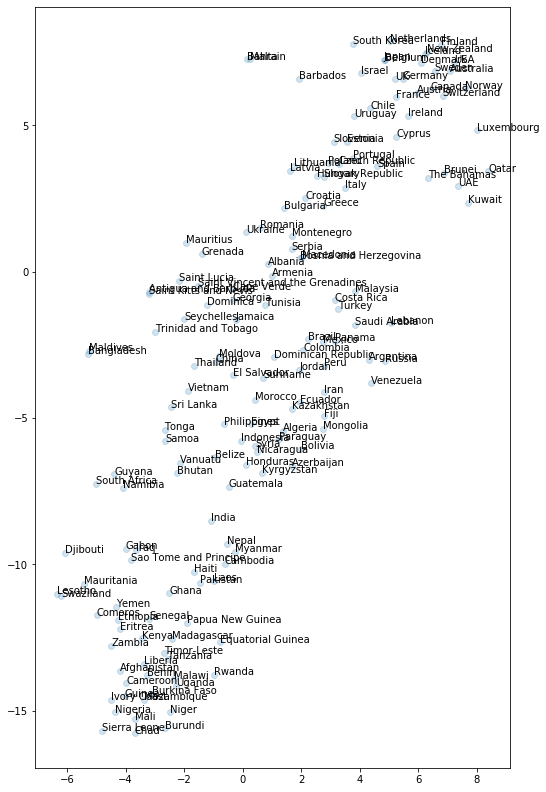

In [41]:
p1,p2 = tsne_results[:,0], tsne_results[:,1]

fig,ax = plt.subplots(figsize=(14,14))
ax.scatter(p1, p2, alpha=.2)
for x,y,s in zip(p1,p2,countries['Country Name']):
    plt.text(x,y,s)
# Force the plot to have equal aspect ratio, i.e. one unit on the x-axis = one unit on the y-axis
ax.set_aspect('equal')
#ax.set_aspect allows a set of aspect of the axis scaling, i.e. the ratio of y-unit and x-unit
#equal gives the same scaling from data to plot units for x and y
plt.show()

<div style="height: 15em"></div>

# 2. Assignment

In [97]:
url = 'https://raw.githubusercontent.com/ekochmar/cl-datasci-pnp/master/DSPNP_practical1/housing/housing.csv'
housing = pandas.read_csv(url)
features = ['housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value']

**Question 1.** Use principal components analysis (PCA) on the above list of features. You should scale the columns appropriately. Plot a scatter plot of the first two components, and colour-code the points by `ocean_proximity`.

Note: A quick and dirty way to colour-code a scatter plot in `matplotlib` is with
```
for lvl in distinct levels of some feature z:
    i = (z == lvl)
    plt.scatter(x[i], y[i], label=lvl)
plt.legend(loc='upper left', bbox_to_anchor=(1.1, 1))
```

False
0
1
2
3
4


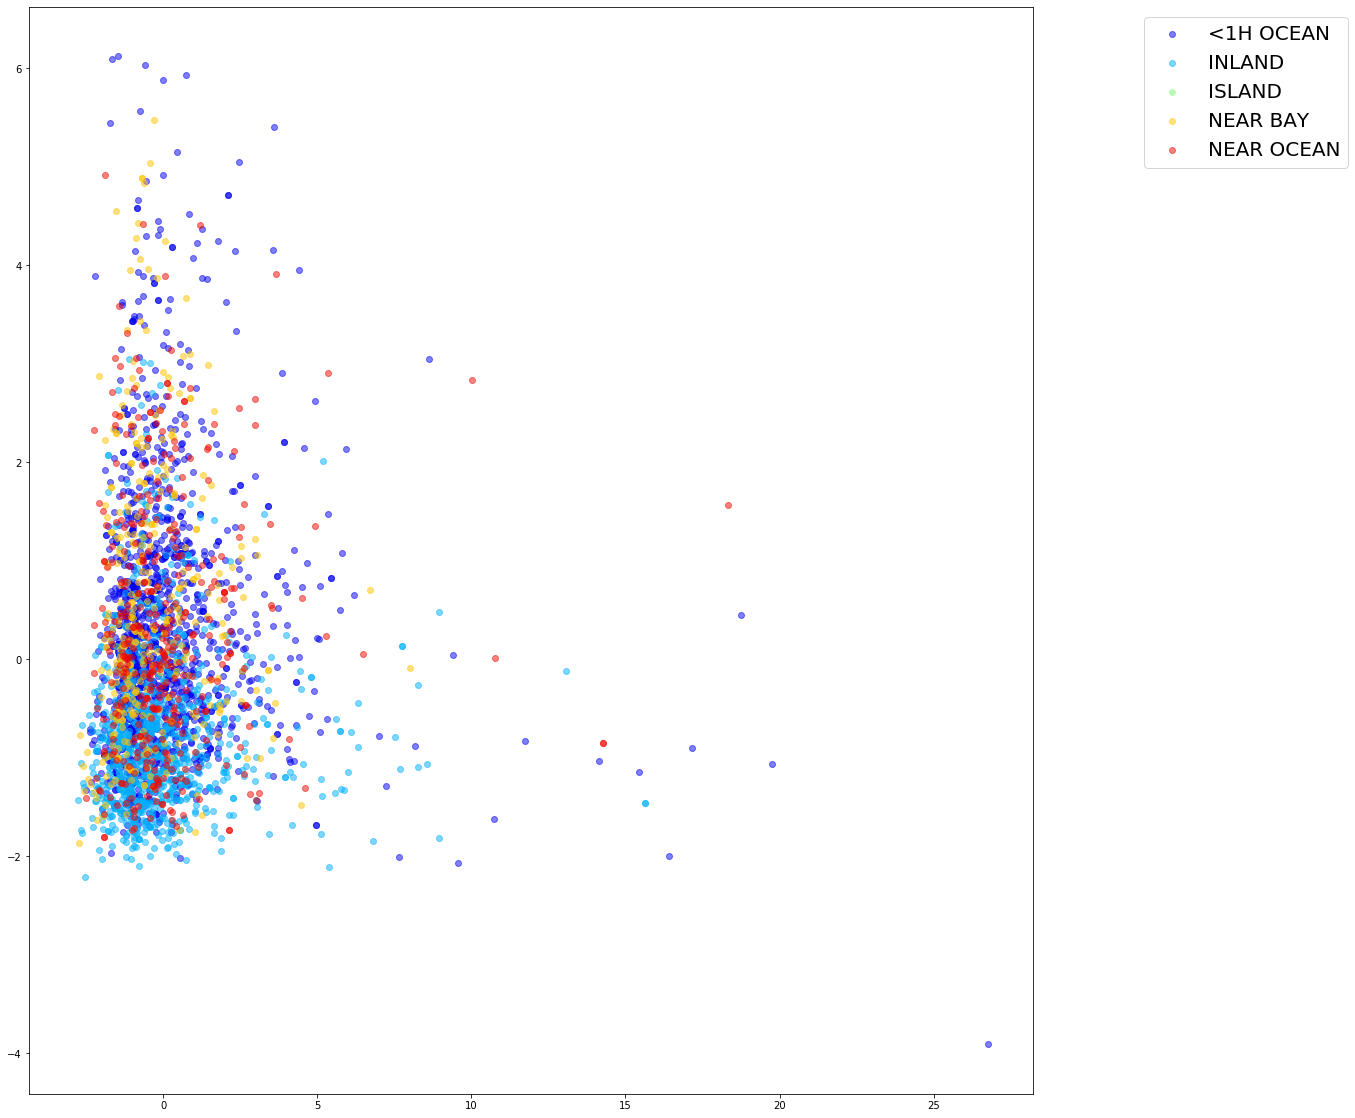

In [105]:
import sys
from sklearn.preprocessing import LabelEncoder
from numpy.random import randint
from numpy.random import seed
np.set_printoptions(threshold=sys.maxsize)

for i in features:
    median = housing[i].median()
#     housing[i] = pandas.to_numeric(housing[i], errors='coerce')
    housing[i].fillna(median, inplace=True)

seed(0)
inx = randint(0, 20640, size=3000)
print(housing[features].isnull().values.any())
X = housing[features].values[inx]

# rescale the features, so they have the same variance
for k in range(len(features)):
    X[:,k] = X[:,k] / np.std(X[:,k])

pca = sklearn.decomposition.PCA()
pca_result = pca.fit_transform(X)
p1,p2 = pca_result[:,0], pca_result[:,1]

encoder = LabelEncoder()
op = encoder.fit_transform(housing["ocean_proximity"][inx])
cmap = matplotlib.cm.get_cmap('jet') # return a colored map with specific name 'jet'
cdict = {0: cmap(0.1), 1: cmap(0.3), 2:cmap(0.5), 3: cmap(0.7), 4: cmap(0.9)} 
fig,ax = plt.subplots(figsize=(18,20))
for lvl in np.unique(op):
    print(lvl)
    i = np.where(op == lvl)
    ax.scatter(p1[i], p2[i], label=np.unique(housing['ocean_proximity'])[lvl], marker='o', alpha=0.5, c=[cdict[lvl]])
plt.legend(loc='upper left', bbox_to_anchor=(1.1, 1),prop={'size': 20})
plt.show()

**Question 2.** Answer question 1 but using t-SNE rather than PCA. Which method seems to produce more helpful clustering?

Note: For speed, you may like to answer questions 1 and 2 working with a subset of several thousand rows, rather than using the full dataset, because t-SNE is slow.

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 3000 samples in 0.001s...
[t-SNE] Computed neighbors for 3000 samples in 0.085s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3000
[t-SNE] Computed conditional probabilities for sample 2000 / 3000
[t-SNE] Computed conditional probabilities for sample 3000 / 3000
[t-SNE] Mean sigma: 0.367079
[t-SNE] KL divergence after 250 iterations with early exaggeration: 74.647766
[t-SNE] KL divergence after 1000 iterations: 1.209235
0
1
2
3
4


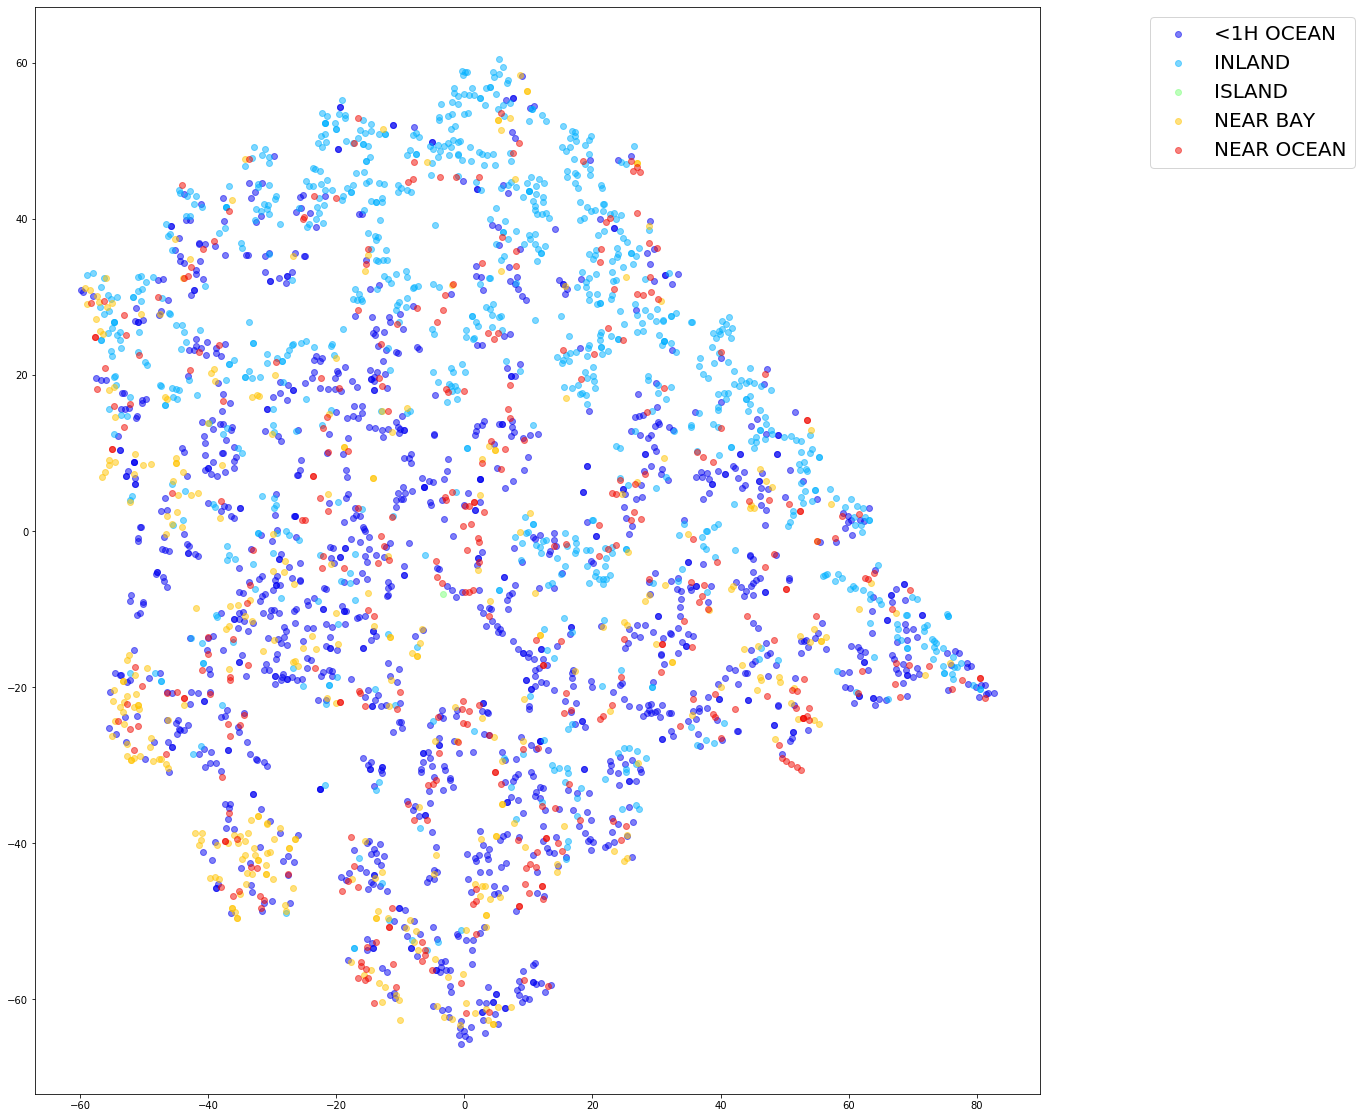

In [101]:
tsne = sklearn.manifold.TSNE(n_components=2, verbose=1)
#for tSNE, you MUST tell how many components to keep
tsne_results = tsne.fit_transform(X)

p1,p2 = tsne_results[:,0], tsne_results[:,1]
encoder = LabelEncoder()
op = encoder.fit_transform(housing["ocean_proximity"][inx])
cmap = matplotlib.cm.get_cmap('jet') # return a colored map with specific name 'jet'
cdict = {0: cmap(0.1), 1: cmap(0.3), 2:cmap(0.5), 3: cmap(0.7), 4: cmap(0.9)} 
fig,ax = plt.subplots(figsize=(18,20))
for lvl in np.unique(op):
    print(lvl)
    i = np.where(op == lvl)
    ax.scatter(p1[i], p2[i], label=np.unique(housing['ocean_proximity'])[lvl], marker='o', alpha=0.5, c=[cdict[lvl]])
plt.legend(loc='upper left', bbox_to_anchor=(1.1, 1),prop={'size': 20})
# ax.set_aspect('equal')
plt.show()

#I think tSNE works better for clustering compared to PCA

**Question 3.** In the t-SNE plot in Section 1.4 above, why did I use `set_aspect('equal')`? Why didn't I choose to use it for the PCA plot?

> Using set_aspect('equal') sets every unit of distance on x and y axes the same for tSNE graph.  
This is because unlike tSNE, which uses normal distribution of the relationship between each point and its neighbour points, and tries to recover the neighbour points using the distribution in the lower-dimensional space by minimizing the distribution of the location of the points between two spaces with different dimensionalities, whereas PCA uses eigenvector and covariance to do linear projection of data points from the high-dimensional space to a lower-dimensional space and selects the eigenvectors with the largest eigenvalues as the principle components. Hence a unit of distance in different components has different weights. Therefore, using equal aspect ratio for PCA is misleading. 

**Question 4.** Repeat question 2 but using a range of values of perplexity, in the range \[5,50\]. Do you see different clustering for different values of perplexity?

Note: perplexity is mentioned in the [sklearn.manifold.TSNE reference](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html). Here's a good read on [how to use t-SNE effectively](https://distill.pub/2016/misread-tsne/).

[5, 10, 20, 35, 45]
[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 3000 samples in 0.001s...
[t-SNE] Computed neighbors for 3000 samples in 0.048s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3000
[t-SNE] Computed conditional probabilities for sample 2000 / 3000
[t-SNE] Computed conditional probabilities for sample 3000 / 3000
[t-SNE] Mean sigma: 0.209795
[t-SNE] KL divergence after 250 iterations with early exaggeration: 84.831268
[t-SNE] KL divergence after 1000 iterations: 1.099836
0
1
2
3
4


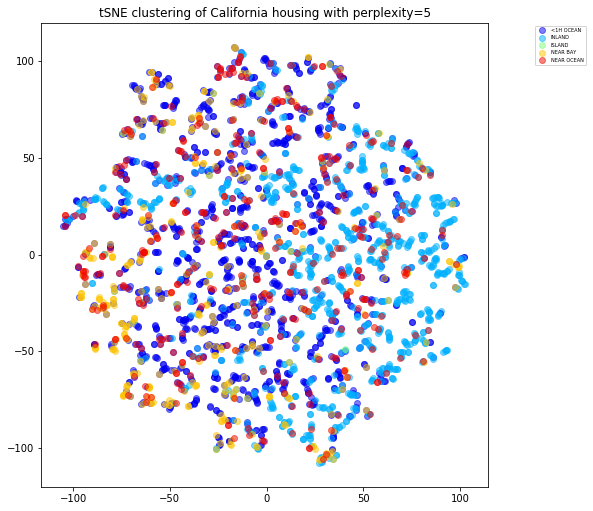

[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 3000 samples in 0.001s...
[t-SNE] Computed neighbors for 3000 samples in 0.050s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3000
[t-SNE] Computed conditional probabilities for sample 2000 / 3000
[t-SNE] Computed conditional probabilities for sample 3000 / 3000
[t-SNE] Mean sigma: 0.268369
[t-SNE] KL divergence after 250 iterations with early exaggeration: 81.904167
[t-SNE] KL divergence after 1000 iterations: 1.191628
0
1
2
3
4


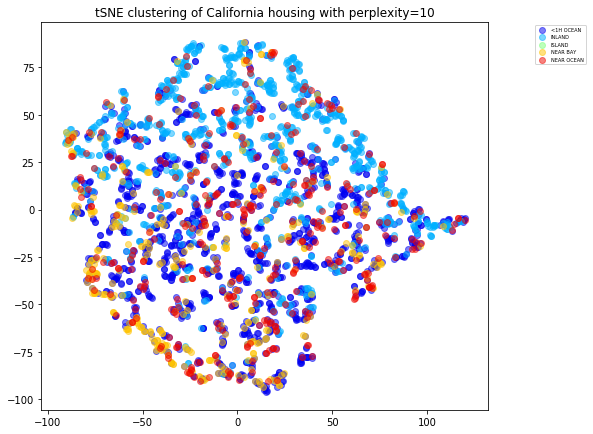

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 3000 samples in 0.001s...
[t-SNE] Computed neighbors for 3000 samples in 0.073s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3000
[t-SNE] Computed conditional probabilities for sample 2000 / 3000
[t-SNE] Computed conditional probabilities for sample 3000 / 3000
[t-SNE] Mean sigma: 0.328358
[t-SNE] KL divergence after 250 iterations with early exaggeration: 77.576820
[t-SNE] KL divergence after 1000 iterations: 1.226873
0
1
2
3
4


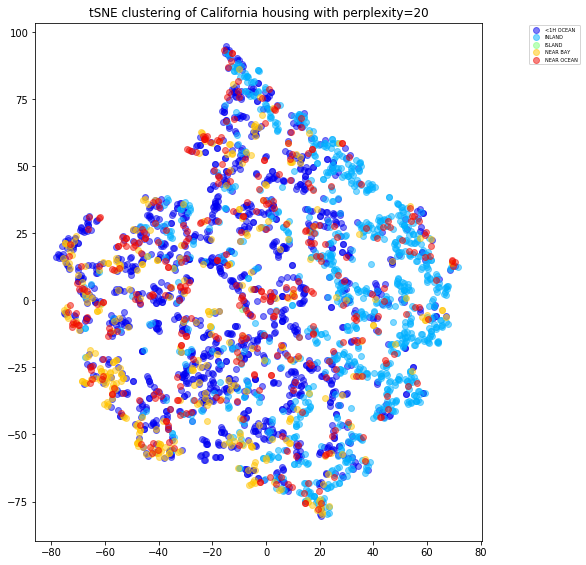

[t-SNE] Computing 106 nearest neighbors...
[t-SNE] Indexed 3000 samples in 0.001s...
[t-SNE] Computed neighbors for 3000 samples in 0.098s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3000
[t-SNE] Computed conditional probabilities for sample 2000 / 3000
[t-SNE] Computed conditional probabilities for sample 3000 / 3000
[t-SNE] Mean sigma: 0.382890
[t-SNE] KL divergence after 250 iterations with early exaggeration: 73.482033
[t-SNE] KL divergence after 1000 iterations: 1.199766
0
1
2
3
4


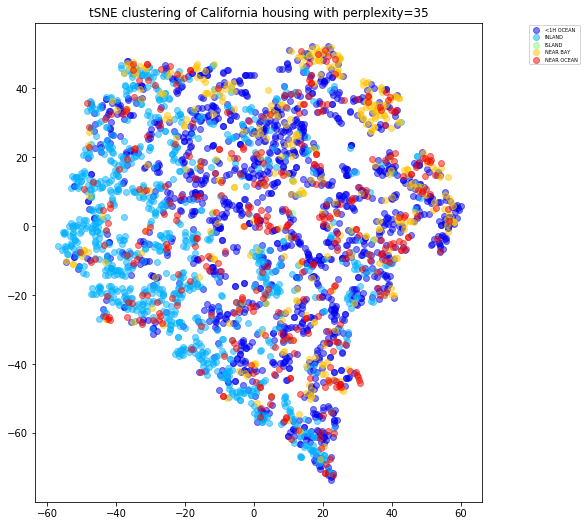

[t-SNE] Computing 136 nearest neighbors...
[t-SNE] Indexed 3000 samples in 0.001s...
[t-SNE] Computed neighbors for 3000 samples in 0.118s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3000
[t-SNE] Computed conditional probabilities for sample 2000 / 3000
[t-SNE] Computed conditional probabilities for sample 3000 / 3000
[t-SNE] Mean sigma: 0.410263
[t-SNE] KL divergence after 250 iterations with early exaggeration: 71.543877
[t-SNE] KL divergence after 1000 iterations: 1.170341
0
1
2
3
4


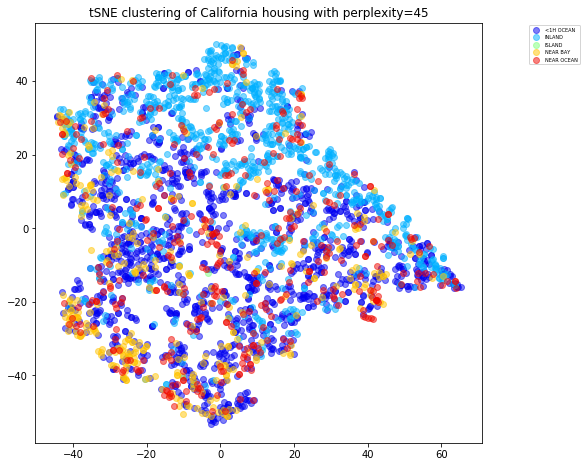

In [102]:
seed(0)
per_l= list([5, 10, 20, 35, 45])
print(per_l)
for per in per_l:
    tsne = sklearn.manifold.TSNE(n_components=2, verbose=1, perplexity=per)
    #for tSNE, you MUST tell how many components to keep
    tsne_results = tsne.fit_transform(X)

    p1,p2 = tsne_results[:,0], tsne_results[:,1]
    encoder = LabelEncoder()
    op = encoder.fit_transform(housing["ocean_proximity"][inx])
    cmap = matplotlib.cm.get_cmap('jet') # return a colored map with specific name 'jet'
    cdict = {0: cmap(0.1), 1: cmap(0.3), 2:cmap(0.5), 3: cmap(0.7), 4: cmap(0.9)} 
    fig,ax = plt.subplots(figsize=(8,10))
    for lvl in np.unique(op):
        print(lvl)
        i = np.where(op == lvl)
        ax.scatter(p1[i], p2[i], label=np.unique(housing['ocean_proximity'])[lvl], marker='o', alpha=0.5, c=[cdict[lvl]])
    plt.legend(loc='upper left', bbox_to_anchor=(1.1, 1),prop={'size': 5})
    ax.set_aspect('equal')
    plt.title(f"tSNE clustering of California housing with perplexity={per}")
    plt.show()

**Question 5.** Run PCA as in question 1. Let $X$ be the full feature matrix, of size $n\times K$, and let $\tilde{X}^L$ be the approximation to $X$ using only the first $L$ principal components, $L=0,\dots,K$. Plot a bar chart with $L$ on the $x$-axis, and the mean square error 
$$
\operatorname{MSE} = \frac{1}{n}\sum_{i=1}^n \sum_{k=1}^K(X_{i,k}-\tilde{X}^L_{i,k})^2
$$ on the $y$-axis.

Hint: [`plt.bar(x,y)`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.bar.html) plots a bar char.

No handles with labels found to put in legend.


RangeIndex(start=0, stop=20640, step=1)
       longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0        -122.23     37.88                41.0        880.0           129.0   
1        -122.22     37.86                21.0       7099.0          1106.0   
2        -122.24     37.85                52.0       1467.0           190.0   
3        -122.25     37.85                52.0       1274.0           235.0   
4        -122.25     37.85                52.0       1627.0           280.0   
...          ...       ...                 ...          ...             ...   
20635    -121.09     39.48                25.0       1665.0           374.0   
20636    -121.21     39.49                18.0        697.0           150.0   
20637    -121.22     39.43                17.0       2254.0           485.0   
20638    -121.32     39.43                18.0       1860.0           409.0   
20639    -121.24     39.37                16.0       2785.0           616.0   

       popu

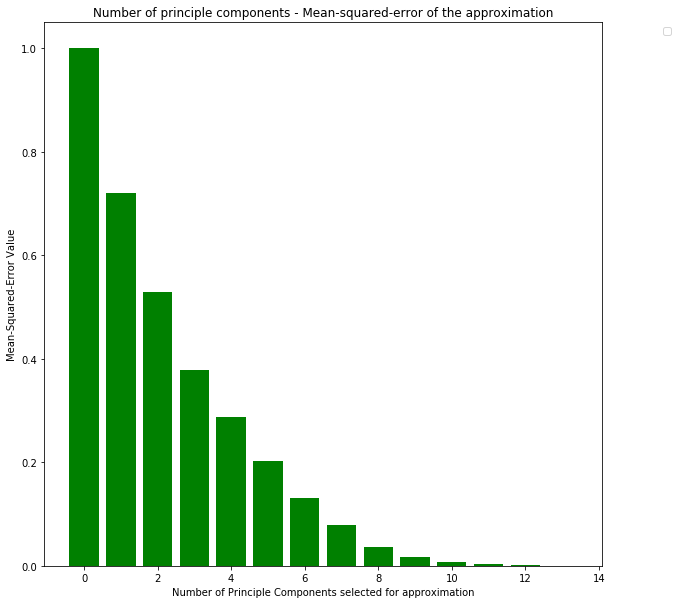

In [103]:
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelBinarizer

encoder = LabelBinarizer()
housing_cat_1hot = encoder.fit_transform(housing["ocean_proximity"])
extra_attr = encoder.classes_
df_op = pandas.DataFrame(data=housing_cat_1hot, columns=extra_attr)
print(df_op.index)
# fit_transform expects a 2D array, but housing_cat_encoded is a 1D array.
# Reshape it using NumPy's reshape functionality where -1 simply means "unspecified" dimension 
# shape dimensionality being -1 means the shape is inferred from the length of the array
#remove the string attributes
full_f = housing.drop(columns=['ocean_proximity'])
for i in full_f.columns:
    median = full_f[i].median()
    full_f[i].fillna(median, inplace=True)
    
full_f = full_f.join(df_op, how='outer')
print(full_f)
full_f.isnull().values.any()
X_f = full_f.values
#randomly selected an array of values from the full-matrix values
# seed(0)
# inx = randint(0, 20640, size=3000)
# X_f = X_f[inx]
# print(X_f.shape)

# rescale the features, so they have the same variance
for k in range(len(full_f.columns)):
    X_f[:,k] = X_f[:,k] / np.std(X_f[:,k])
    
pca = sklearn.decomposition.PCA()
pca_result = pca.fit_transform(X_f)
print(pca_result.shape)
print(pca.components_.shape)
fig,ax = plt.subplots(figsize=(10,10))
μ = pca.mean_
print(μ.shape)

#L is the number of principle components used
#for each 
for L in range(X_f.shape[1]):
    X_approx = μ + np.zeros_like(pca_result)
    for k in range(L): # L = number of PCA components to use
        λk = pca_result[:,k] #kth feature 
        δk = pca.components_[k] 
        X_approx = X_approx + λk.reshape((-1,1)) * δk.reshape((1,-1))
    plt.bar(L, mean_squared_error(X_f, X_approx), color='g')
        #nagetive value in reshape: it doesnt know the dimension and leave it for numpy to figure out
plt.legend(loc='upper left', bbox_to_anchor=(1.1, 1),prop={'size': 10})
plt.title("Number of principle components - Mean-squared-error of the approximation")
plt.xlabel("Number of Principle Components selected for approximation")
plt.ylabel("Mean-Squared-Error Value")
plt.show()

**Question 6.** We'd like to decide how many components to use with PCA.
The number of components to use, call it $L$, is a hyperparameter, and the usual way to choose a hyperparameter is by cross validation.
But it takes some thinking to find a good way to run cross validation on an autoencoder...
Suppose we've implemented PCA as a pair of functions
* `enc(X,L)` which encodes a $n\times K$ dataset $X$ into a $n\times L$ matrix, keeping the first $L$ components for each record
* `dec(Λ)` which decodes a $n\times L$ set of components into a $n\times K$ reconstruction of the data

The naive approach to cross validation would be to train `enc,dec` on a training set of data, to set aside a test set `Xtest`, and to pick $L$ to make
the reconstruction `dec(enc(Xtest,L))` as close as possible to the original `Xtest`. But this is useless, because $L=K$ will always yield perfect reconstruction.

An alternative approach is to measure *denoising ability*. If we see this picture 

<div>
<img src="weasey6.jpg" style="height:8em"/>
</div>

we don't think "This is a weasel with no back legs", we think "This is a normal weasel and its back legs are occluded". In other words, from the occluded image, we can find the low-dimensional latent representation "this is a weasel", from which we can predict how the animal would look it it weren't occluded. This is called *denoising*.

Likewise, we can measure the performance of an autoencoder by the difference between `Xtest` and `dec(enc(n(Xtest),L))` where `n` is some function that adds noise.

Your task is to use cross-validation to pick the optimal number of components $L$ to use, as measured by denoising ability for the two types of noise below. Here is a code skeleton to
get you started.

```
def noisify_gaussian(x): 
    σ = np.std(x, axis=0)
    return np.random.normal(loc=x, scale=σ)

def noisify_mask(x):
    μ = np.mean(x, axis=0)
    n,K = x.shape
    k = np.random.choice(np.arange(K), size=n)
    y = np.copy(x)
    y[np.arange(n), k] = μ[k]
    return y

def train_model(X):
    ...
    def enc(Xnew, L):
        return ...
    def dec(Λ):
        return ...
    return enc,dec    

# Sanity check, on a single train/test split

df = housing.dropna(subset=features)
X = df[features].values
n,K = X.shape

i_train, i_test = next(kf.split(np.arange(n)))
Xtrain, Xtest = X[i_train], X[i_test]
enc,dec = train_model(Xtrain)

# We should get perfect reconstruction, if we use all K components
assert np.allclose(dec(enc(Xtest,K)), Xtest)
# Imperfect reconstruction, if we use fewer
assert not np.allclose(dec(enc(Xtest,K-1)), Xtest)

# Denoising, using 3 components
dec(enc(noisify_mask(Xtest),3))
```

In [78]:
features = ['housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value']
from sklearn.model_selection import KFold

#to add noise to row x (x is array-like here)
def noisify_gaussian(x): 
    σ = np.std(x, axis=0)
    #std is performed along the row
    return np.random.normal(loc=x, scale=σ) #qn: why is center an arary here?
#np.random.normal: draw random samples from the distribution
#loc: mean of the distribution
#scale: std of the distribution

def noisify_mask(x):
    μ = np.mean(x, axis=0)
    n,K = x.shape #here x is a 2D array
    #n: number of samples
    #K: number of features
    k = np.random.choice(np.arange(K), size=n) #generates a random array of size n from range of K features
    y = np.copy(x)
    y[np.arange(n), k] = μ[k] #np.arange: return evenly spaced elements 
    #这行把选中的一些elements换成mu，i.e. average value
    return y

def train_model(X):
    for k in range(X.shape[1]):
        X[:,k] = X[:,k] / np.std(X[:,k])
    pca = sklearn.decomposition.PCA()
    model = pca.fit(X)
    
    def enc(Xnew, L):
        return model.transform(Xnew)[:,:L]
    def dec(Λ):
        μ = pca.mean_
        print(X.shape[1])
        print(Λ.shape[0])
        X_o = μ + np.zeros((Λ.shape[0],X.shape[1]))
        for k in range(Λ.shape[1]): # L = number of PCA components to use
            #Λ is the result of transforming PCA here
            λk = Λ[:,k]
            δk = pca.components_[k]
            X_o = X_o + λk.reshape((-1,1)) * δk.reshape((1,-1))
        return X_o
    return enc,dec   

# Sanity check, on a single train/test split

df = housing.dropna(subset=features)
X = df[features].values
n,K = X.shape

kf = KFold(n_splits=2)
i_train, i_test = next(kf.split(np.arange(n)))
Xtrain, Xtest = X[i_train], X[i_test]
enc,dec = train_model(Xtrain)

# We should get perfect reconstruction, if we use all K components
#allclose: compare the two given arrays
assert np.allclose(dec(enc(Xtest,K)), Xtest)
# Imperfect reconstruction, if we use fewer
print("Shape of encoded matrix:" + str(enc(Xtest,6).shape))
print("Shape of orginal matrix:" + str(Xtest.shape))
print(pca.get_params())
assert not np.allclose(dec(enc(Xtest,K-1)), Xtest)

# Denoising, using 3 components
dec(enc(noisify_mask(Xtest),3)).shape

7
10320
Shape of encoded matrix:(10320, 6)
Shape of orginal matrix:(10320, 7)
{'copy': True, 'iterated_power': 'auto', 'n_components': None, 'random_state': None, 'svd_solver': 'auto', 'tol': 0.0, 'whiten': False}
7
10320
7
10320


(10320, 7)

**Question 7 (optional).** Use PCA on the the expanded set of features consisting of `features` as specified in the assignment, plus `ocean_proximity` encoded numerically. 
Explain how you have chosen to encode it, and how you will scale the columns. Apply PCA, and plot the first two components. Is the output more useful than that of question 1?

## Question:
>_1. What does mu, delta and lambda mean here, and how does the formula used here correlate to how PCA is supposed to be calculated(i.e. eigenvalues and eigenvectors, etc.)_
        - __mu: the mean value of each column. delta: the __
>_2. Are there meaningful interpretations for the two axes after dimensionality-reduction using PCA and tSNE? (e.g. what do x-axis and y-aixs mean in this case after dimensionality reduction)_
> 
>_3. Why does the randomly chosen data not include 'NEAR_OCEAN' for the first four tSNE graph with different perplexity_
        - __coz you got the stupid messed-up code in your code space lmao....__
>_4. For question 5: Should we use number encoding for ocean proximity here if the variance of the values is calculated, although big or small difference between the number encoding doesn't matter?_  
        - __should actually use one-hot and add it to the dataframe__
>_5.For question 5: Confusion: relation between number of components in PCA and the number of columns in the dataset. -> seems like in this case, no matter the value of L, X_approx has the same shape as original dataset?_
        - __The number of components used in PCA is not related to the number of features for each data point!!!__
        
- Question extended from the last part: you can plot the 